In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from mplsetup import rcsetup
rcsetup()
rcsetup()

In [2]:
import sys
sys.path.insert(0, '/more-is-better')
from exptdetails import ExptDetails
from utils import int_logspace

In [3]:
def get_color(i):
    colors = ["xkcd:azure", "xkcd:pumpkin", "xkcd:grass", "xkcd:coral", "xkcd:periwinkle"]
    return colors[i%5]

In [21]:
DATASET_NAME = 'cifar10'
EXPT_NUM = 0
DEPTH = 10

expt = ExptDetails(EXPT_NUM, DEPTH, DATASET_NAME)
work_dir = f"eigdata/eigdata/{expt.expt_name}"
with open(f"{work_dir}/eigdata.file", 'rb') as handle:
    eigdata = pickle.load(handle)
with open(f"{work_dir}/eigdebug.file", 'rb') as handle:
    eigstats = pickle.load(handle)

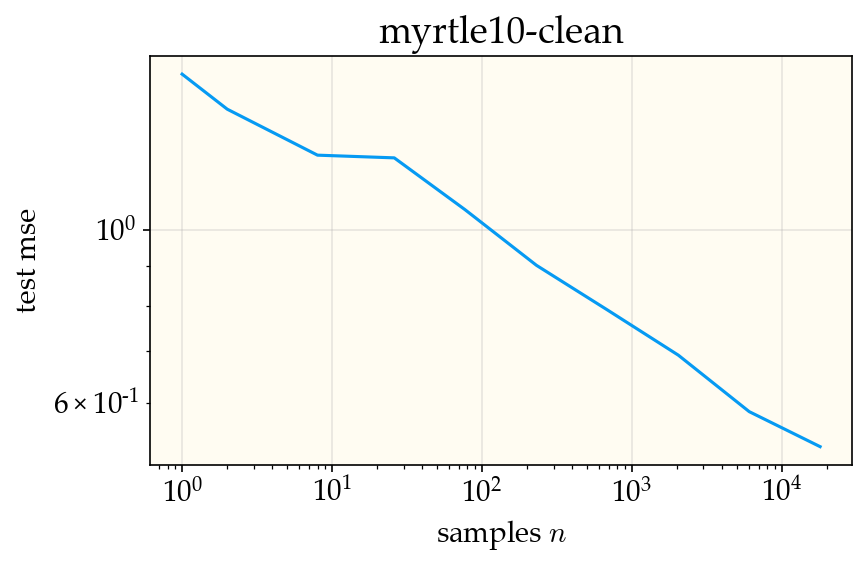

In [23]:
ax = plt.gca()

color = get_color(0)
sizes = eigstats["sizes"]
test_mses = eigstats["test_mses"]
test_mse = test_mses.mean(axis=0)
train_mses = eigstats["train_mses"]
train_mse = train_mses.mean(axis=0)
n_trials = test_mses.shape[0]

ax.plot(sizes, test_mse, color=get_color(0))
# ax.plot(sizes, train_mse, color=get_color(1))

ax.set_title(f"{expt.expt_name}")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('samples $n$')
ax.set_ylabel('test mse')
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()

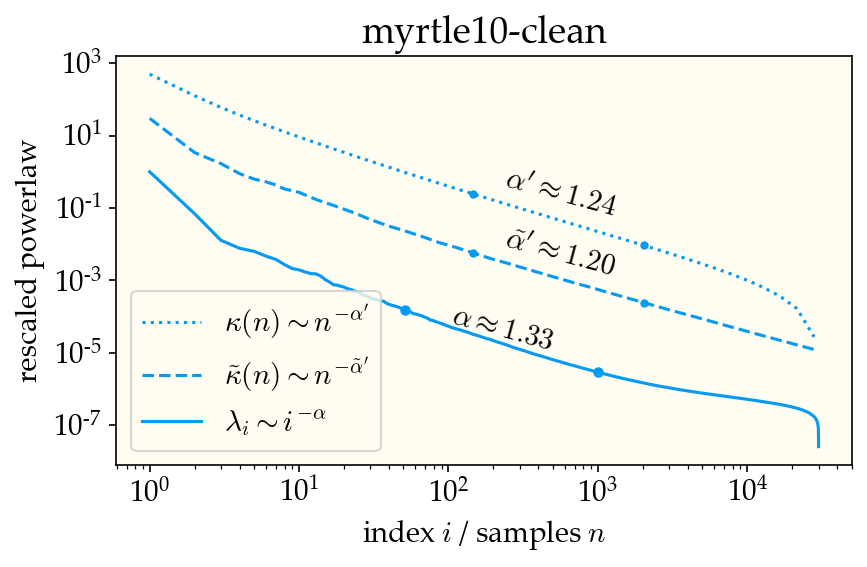

In [26]:
ax = plt.gca()

sizes = int_logspace(0, np.log10(28000), num=40, base=10)
eigvals = eigdata[30000]["eigvals"]
n = len(eigvals)
idxs = 1 + np.arange(n)

f1, f2 = 500, 30
all_endpts = [[50, 1000], [30, 1000], [80, 6000], [20, 300]]
rot = -15
lift = 1.6

kappas = eigstats["true_kappas"]
kappas /= kappas.max()
kappa_estims = eigstats["kappa_estimates"]
kappa_estims /= kappa_estims.max()
eigvals = eigvals / eigvals[0]
color = get_color(0)
ax.plot(sizes, f1*kappas, color=color, ls=":", label="$\\kappa(n)\\sim n^{-\\alpha'}$")
ax.plot(sizes, f2*kappa_estims, color=color, ls="--", label="$\\tilde{\\kappa}(n)\\sim n^{-\\tilde{\\alpha}'}$")
ax.plot(idxs, eigvals, color=color, label="$\\lambda_i\\sim i^{-\\alpha}$")

start, end = 19, 25
endpts = [start, start+10]
x1, x2 = sizes[endpts]
y1, y2 = f2 * kappa_estims[endpts]
alpha3 = -np.log(y2/y1) / np.log(x2/x1)
ax.plot((x1, x2), (y1, y2), color=color, ls='none',
        marker='.', markersize=6)
x_mid = int(np.sqrt(x1 * x2))
y_mid = lift*f2 * kappa_estims[(start+end)//2]
ax.text(x_mid, y_mid, f"$\\tilde{{\\alpha}}'\\approx{alpha3:.2f}$",
        rotation=rot, rotation_mode="anchor", ha='center')

# start, end = 15, 25
# endpts = [start, end]
x1, x2 = sizes[endpts]
y1, y2 = f1 * kappas[endpts]
alpha2 = -np.log(y2/y1) / np.log(x2/x1)
ax.plot((x1, x2), (y1, y2), color=color, ls='none',
        marker='.', markersize=6)
x_mid = int(np.sqrt(x1 * x2))
y_mid = lift*f1 * kappas[(start+end)//2]
ax.text(x_mid, y_mid, f"${{\\alpha}}'\\approx{alpha2:.2f}$",
        rotation=rot, rotation_mode="anchor", ha='center')

endpts = all_endpts[0]
x1, x2 = idxs[endpts]
y1, y2 = eigvals[endpts]
alpha = -np.log(y2/y1) / np.log(x2/x1)
ax.plot((x1, x2), (y1, y2), color=color, ls='none',
        marker='.', markersize=8)
x_mid = int(np.sqrt(x1 * x2))
ax.text(x_mid, lift*eigvals[x_mid], f"$\\alpha\\approx{alpha:.2f}$",
        rotation=rot, rotation_mode="anchor", ha='center')


ax.legend(loc="lower left")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(expt.expt_name)

plt.xlabel("index $i$ / samples $n$")
plt.ylabel("rescaled powerlaw")

plt.tight_layout()
plt.show()

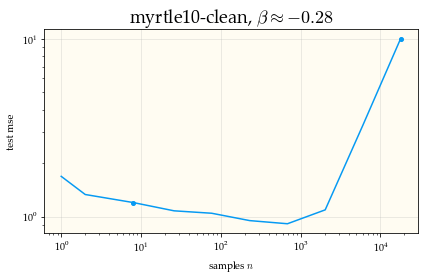

In [7]:
ax = plt.gca()

color = get_color(0)
sizes = eigstats["sizes"]
test_mses = eigstats["test_mses"]
test_mean, test_std = test_mses.mean(axis=0), test_mses.std(axis=0)
n_trials = test_mses.shape[0]

ax.errorbar(sizes, test_mean, yerr=test_std/np.sqrt(n_trials), ls='none', color=color)

start, end = 10, len(sizes)-1
endpts = [start, end]
x1, x2 = sizes[endpts]
y1, y2 = test_mean[endpts]
beta = -np.log(y2/y1) / np.log(x2/x1)
ax.plot((x1, x2), (y1, y2), color=color, ls='none',
        marker='.', markersize=8)

ax.set_title(f"{expt.expt_name}, $\\beta\\approx{{{beta:.2f}}}$")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('samples $n$')
ax.set_ylabel('test mse')
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()